<a href="https://colab.research.google.com/github/123shwetarohokale/563-ShwetaR/blob/main/Week7_MD_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Running for dt = 0.0005

Running for dt = 0.001

Running for dt = 0.005

Running for dt = 0.01


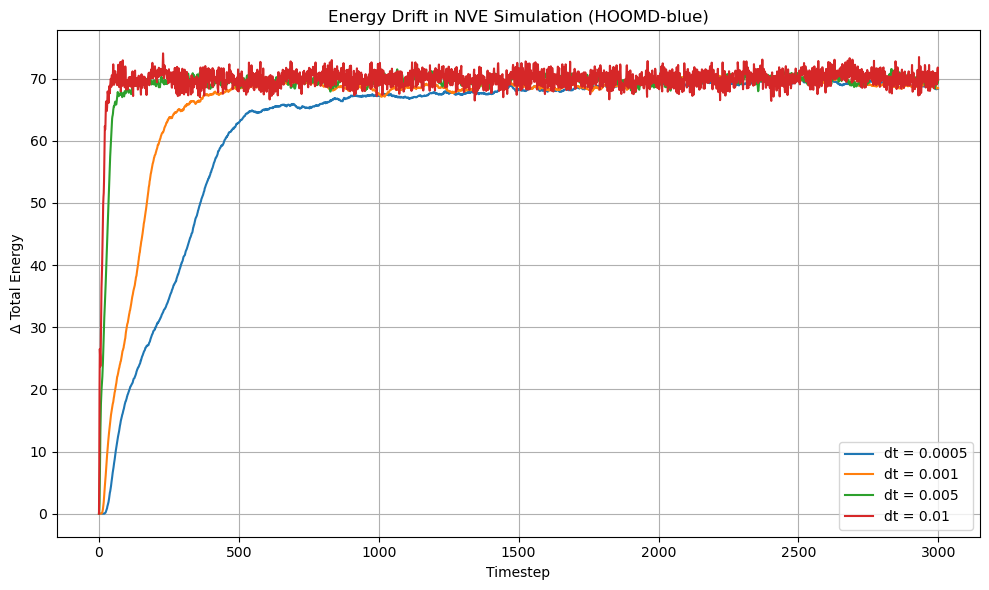

In [ ]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt

def run_nve_simulation(N=512, density=1.0, dt=0.001, steps=5000):
    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)

    # Calculate box size
    L = (N / density)**(1/3)

    # Create snapshot
    snapshot = hoomd.Snapshot()
    snapshot.particles.N = N
    snapshot.particles.types = ['A']
    snapshot.particles.mass[:] = [1.0] * N
    snapshot.particles.typeid[:] = [0] * N
    snapshot.configuration.box = [L, L, L, 0, 0, 0]

    # Place particles on a cubic lattice
    nx = ny = nz = int(np.ceil(N ** (1/3)))
    spacing = L / nx
    positions = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if len(positions) < N:
                    x = (i + 0.5) * spacing - 0.5 * L
                    y = (j + 0.5) * spacing - 0.5 * L
                    z = (k + 0.5) * spacing - 0.5 * L
                    positions.append([x, y, z])
    snapshot.particles.position[:] = positions

    # Assign velocities from Maxwell-Boltzmann distribution
    T_init = 1.0  # in LJ units
    velocities = np.random.normal(0, np.sqrt(T_init), size=(N, 3))
    snapshot.particles.velocity[:] = velocities

    sim.create_state_from_snapshot(snapshot)

    # Define LJ pair potential with buffer
    nl = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=nl)
    lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
    lj.r_cut[('A', 'A')] = 2.5

    # NVE integrator (ConstantVolume)
    integrator = hoomd.md.Integrator(dt=dt)
    nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())
    integrator.methods.append(nve)
    integrator.forces.append(lj)
    sim.operations.integrator = integrator

    # Thermo for energy tracking
    thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermo)

    sim.run(0)  # initialize

    energies = []
    for _ in range(steps):
        sim.run(1)
        KE = thermo.kinetic_energy
        PE = thermo.potential_energy
        energies.append(KE + PE)

    return np.array(energies)

# Try different dt values
dts = [0.0005, 0.001, 0.005, 0.01]
total_energies = {}

for dt in dts:
    print(f"\nRunning for dt = {dt}")
    try:
        E = run_nve_simulation(dt=dt, steps=3000)
        total_energies[dt] = E
    except Exception as e:
        print(f"dt={dt} failed: {e}")

# Plot energy drift
plt.figure(figsize=(10, 6))
for dt, E in total_energies.items():
    plt.plot(E - E[0], label=f'dt = {dt}')
plt.xlabel('Timestep')
plt.ylabel('Δ Total Energy')
plt.title('Energy Drift in NVE Simulation (HOOMD-blue)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
